In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import pi, cos, sin
plt.style.use('fivethirtyeight')

# Augmented solution for one-bar linkage

## Overview: embedding technique
The __augmented technique__ is a generalized method to solve for the dynamic response in a system of moving parts. The system of _differential algebraic equations_ (DAE) are solve for all generalized coordinates and constraint forces in a system of equations, 

$\left[\begin{array}
~\mathbf{M} & \mathbf{C_q}^T \\
\mathbf{C_q} & \mathbf{0} \end{array}\right]
\left[\begin{array}
~\mathbf{\ddot{q}} \\
\mathbf{\lambda}\end{array}\right]=
\left[\begin{array}
~\mathbf{Q_e}  \\
\mathbf{Q_d}\end{array}\right]$

where 

- $\mathbf{M}$ is a diagonal mass matrix for each body, 
- $\mathbf{C_q}$ is the Jacobian of the constraint equations, 
- $\ddot{q}$ is the second time derivative of each generalized coordinate, 
- $\mathbf{\lambda}$ is a vector of Lagrange multiplier that decribes the reaction forces at each constraint, 
- $\mathbf{Q_e}$ is a vector of external generalized forces ($F\delta R~and~M\delta \theta$), and
- $\mathbf{Q_d} = -[\mathbf{(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}]$ are the constraints on acceleration.

The resulting linear algebra equation creates $n+n_c$ linearly independent equations. This is much larger than the _embedding technique_ with $n-n_c$ equations, but the left hand side matrix is very sparse. As an example, consider a link pinned to the ground

## System: link pinned to ground

![link pinned to ground](../images/ground-pin.svg)

In the diagram above, a link is pinned to the point $r_{pin} = x\hat{i}$. In this notebook, you will 
- build the system of differential algebraic equations
- solve the DAE's
- plot and animate the results (coordinates and reaction forces)

The system of equations depends upon the variables and equations below. You can expand look at the code cells to see the function definitions using `sympy.lambdify`:
1. $\mathbf{q}$
1. $\dot{\mathbf{q}}$
2. $\mathbf{C}(\mathbf{q},~t)$: `C_link = lambdify ...`
3. $\mathbf{C_q}$:`Cq_link = lambdify ...`
5. $\mathbf{Q_d} = -[\mathbf{(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}]$: `Qd_link = lambdify ...` 

In [2]:
import sympy

### 1. Define generalized coordinates $\mathbf{q}$ and $\dot{\mathbf{q}}$

The generalized coordinates $\mathbf{q} = [R_x^1,~R_y^1,~\theta^1]$, are defined as follows, 

In [3]:
q = sympy.var(['q_'+str(i) for i in range(3)])
q = sympy.Matrix(q)
dq = sympy.var(['\dot{q}_'+str(i) for i in range(3)])
dq = sympy.Matrix(dq)
q

Matrix([
[q_0],
[q_1],
[q_2]])

### 2. $\mathbf{C}(\mathbf{q},~t)$: `C_link = lambdify ...`

The constraints are defined as  $\mathbf{C}(\mathbf{q},~t)=$

In [4]:
sympy.var('L1 ,x, t')

x = 0.2*sympy.sin(0*t)
A = lambda theta: sympy.Matrix([[sympy.cos(theta), -sympy.sin(theta)],
                                [sympy.sin(theta), sympy.cos(theta)]])
C = sympy.Matrix([q[0]-x, q[1]]) + A(q[2])*sympy.Matrix([-L1/2,0])

C_link = sympy.lambdify((q, t, L1), C, 'numpy')
C

Matrix([
[-L1*cos(q_2)/2 + q_0],
[-L1*sin(q_2)/2 + q_1]])

and $\frac{\partial C}{\partial t} = C_t = $

In [5]:
Ct = sympy.diff(C, t)

Ct_link = sympy.lambdify((q, t, L1), Ct, 'numpy')

Ct

Matrix([
[0],
[0]])

### 3. $\mathbf{C_q}$:`Cq_link = lambdify ...`

Then, the Jacobian of constraints, $\mathbf{C_q}=$

In [6]:
Cq = C.jacobian(q)

Cq_link = sympy.lambdify((q, t, L1), Cq, 'numpy')

Cq

Matrix([
[1, 0,  L1*sin(q_2)/2],
[0, 1, -L1*cos(q_2)/2]])

### 4. $\mathbf{Q_d} = -[\mathbf{(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}]$: `Qd_link = lambdify ...` 

The constraints on acceleration, $\mathbf{C_q \ddot{q}} = \mathbf{Q_d} = -[\mathbf{(C_q\dot{q})_q\dot{q}+2C_{qt}\dot{q}+C_{tt}}] = $

In [7]:
Qd = -(Cq*dq).jacobian(q)*dq - 2*sympy.diff(Cq, t)*dq - sympy.diff(C, t, 2)

Qd_link = sympy.lambdify((q, dq, t, L1), Qd, 'numpy')

Qd

Matrix([
[-L1*\dot{q}_2**2*cos(q_2)/2],
[-L1*\dot{q}_2**2*sin(q_2)/2]])

The final set of equations for the __augmented method__ combines the differential and algebraic equations to the final form as such

$\left[\begin{array}
~\mathbf{M} & \mathbf{C_q}^T \\
\mathbf{C_q} & \mathbf{0} \end{array}\right]
\left[\begin{array}
~\mathbf{\ddot{q}} \\
\mathbf{\lambda}\end{array}\right]=
\left[\begin{matrix}
\left[\begin{matrix}m & 0 & 0\\0 & m & 0\\0 & 0 & \frac{L_{1}^{2} m}{12}\end{matrix}\right] & 
\left[\begin{matrix}1 & 0\\0 & 1\\\frac{L_{1} \sin{\left(q_{2} \right)}}{2} & - \frac{L_{1} \cos{\left(q_{2} \right)}}{2}\end{matrix}\right]\\
\left[\begin{matrix}1 & 0 & \frac{L_{1} \sin{\left(q_{2} \right)}}{2}\\0 & 1 & - \frac{L_{1} \cos{\left(q_{2} \right)}}{2}\end{matrix}\right] & 
\left[\begin{matrix}0 & 0\\0 & 0\end{matrix}\right]\end{matrix}\right]
\left[\begin{array}
~\ddot{R}_x^1 \\
\ddot{R}_y^1 \\
\ddot{\theta} \\
\lambda_1\\
\lambda_2\end{array}\right]=
\left[\begin{matrix}~0\\-mg\\0\\ -\frac{L_{1} \dot{q}_2^{2} \cos{\left(q_{2} \right)}}{2}\\- \frac{L_{1} \dot{q}_2^{2} \sin{\left(q_{2} \right)}}{2}\end{matrix}\right]=
\left[\begin{array}
~\mathbf{Q_e}  \\
\mathbf{Q_d}\end{array}\right]
$

Here, you see that the left hand side matrix is $n+n_c\times n+n_c$, but it is very sparse i.e. lots of zeros. Below, the matrix is evaluated with arbitrary inputs and each element is colored black for nonzero and white for zero. 

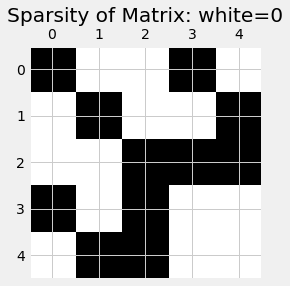

In [8]:
sympy.var('m')
LHS = sympy.BlockMatrix([[sympy.Matrix([[m, 0, 0],[0,m,0],[0,0,m*L1**2/12]]), 
                    Cq.transpose()], 
                   [Cq, sympy.zeros(2)]])
LHS_link = sympy.lambdify((q, m, L1), LHS)
plt.spy(LHS_link(np.ones(3), 1, 1))
plt.title('Sparsity of Matrix: white=0');

## Baumgarte stabilization

The `LHS_link` only constrains the accelerations in the system because

$\mathbf{\ddot{C}} = \mathbf{C_q\ddot{q} - Q_d} = \mathbf{0}$

Numerical solutions use an approximation of differential equations to solve nonlinear problems. The approximation can lead to compounding error at each time step. The unconstrained 

The __Baumgarte stbailization__ adds the first and second derivatives to the acceleration constraints as such

$\mathbf{\ddot{C}} +2\alpha \mathbf{\dot{C}} + \beta^2\mathbf{C} = \mathbf{0}$

where $\alpha$ and $\beta$ are numerical constants that are used to constrain compounding error over time. Now, the $\mathbf{Q_d}$ has two terms added

$\mathbf{C_q \ddot{q}} = \mathbf{Q_d} - 2\alpha(\mathbf{C_q \dot{q}}+\mathbf{C_t}) - \beta^2\mathbf{C}$



## Define DAE and System constants

You will use a 1-meter link with mass, m=0.1 kg. The DAE system is defined in `ode_bar`. Take a look at the function. The main equations are set up using [`np.block`](https://numpy.org/doc/stable/reference/generated/numpy.block.html) as such

```python
A = np.block([[M, Cq.T], 
              [Cq, np.zeros((2,2))]])
```

> __Note__: A more general approach to assemble this matrix would be to take the shape of `np.shape(Cq) = (2, 3)` and set up the `zeros` to match the rows of `Cq`
>
> ```python
> nc, n = np.shape(Cq) 
> A = np.block([[M, Cq.T], 
>               [Cq, np.zeros((nc,nc))]])
> ```

The _Baumgarte stabilization_ is added inside of the `if`-statement, 

```python
if baumgarte == True:
    Qd = Qd-2*alpha*(Cq@y2+Ct)-beta**2*C
```

The added terms are 0 if the solution is exact, but they can add error if `alpha` and `beta` are not tested for convergence. In this example, you can experiment and see that the solution is independent of these parameters. 

The final step to solve the system of DAE is to assemble $Q_e~and~Q_d$, solve and separate $\ddot{\mathbf{q}}$ from $\mathbf{\lambda}$. 

```python
Q=np.hstack((Qe,Qd))
x=np.linalg.solve(A,Q)

dy[len(y2):]=x[0:len(y2)]
L = x[len(y2):]
```




In [59]:
m = 1 # kg
L1 = 1 # m
def ode_bar(t, y, alpha = 0.1, beta = 0.2, baumgarte = True):
    '''
    dy, L = ode_bar(t, y)
    returns the derivative of state, y, and the generalized reaction forces as L 
    for a given time, t
    
    Parameters
    ----------
    t : current time
    y : current state of pinned link, [Rx, Ry, theta, vx, vy, dtheta/dt]
    alpha : Baumgarte stabilization parameter for velocity constraints
    beta : Baumgarte stabilization parameter for position constraints
    baumgarte : default = True, adds the stabilization to the constraint forces `Qd`
                `Qd = Qd-2*alpha*(Cq@y2+Ct)-beta**2*C`
    
    Returns
    -------
    dy : derivative of state of pinned link, [vx, vy, dtheta/dt, ax, ay, ddtheta/ddt]
    L : Lagrange multipliers that represent the reaction forces and moments, -Cq@L = Qc
    '''
    
    dy = np.zeros(y.shape)

    y1, y2 = np.array_split(y, 2)
    dy[0:len(y2)] = y2    

    M = np.diag([m, m, m*L1**2/12])
    C = C_link(y1, t, L1)[:,0] # np.array([y1[0]-1/2*cos(y1[2]),y1[1]-1/2*sin(y1[2])])
    Ct = Ct_link(y1, t, L1)[:, 0]
    Cq = Cq_link(y1, t, L1) # np.array([[1,0,1/2*sin(y1[2])],[0,1,-1/2*cos(y1[2])]])

    A = np.block([[M, Cq.T], 
                [Cq, np.zeros((2,2))]])
    Qe = np.array([0, -m*9.81, 0])
    #Qd=np.array([1/2*y[5]**2*np.cos(y[2]),1/2*y[5]**2*np.sin(y[2])])
    Qd = Qd_link(y1, y2, t, 1)[:, 0]
    if baumgarte == True:
        Qd = Qd-2*alpha*(Cq@y2+Ct)-beta**2*C
    #print(Qd.shape)
    #Q=np.array([0,-9.81,0,1/2*y[5]**2*np.cos(y[2]),1/2*y[5]**2*np.sin(y[2])])
    Q=np.hstack((Qe,Qd))
    x=np.linalg.solve(A,Q)
    
    dy[len(y2):]=x[0:len(y2)]
    L = x[len(y2):]
    return dy, L



## Solve and plot results

Here, you compare the numerical solution to the analytical solution. You will release the link from rest at $\theta=0^o$. The _augmented method_ uses a state, `y`, that includes all of the generalized coordinates and derivatives, `y` $=[\mathbf{q},~\dot{\mathbf{q}}]$. Before integrating over time, solve for the initial state,  

- $\mathbf{C}(\mathbf{q},~t=0) = 0$
- $\mathbf{C_q\dot{q}} = -\mathbf{C}_t$

```python
q0 = fsolve(lambda q: np.hstack([C_link(q, 0, 1)[:,0], q[2]-theta0]), np.zeros(3))
dq0 = np.linalg.solve(np.vstack([Cq_link(q0, 0, L1), np.array([0, 0, 1])]), 
                      np.vstack([-Ct_link(q0, 0, L1), 0]))

y0 = np.zeros(6)
y0[0:3] = q0

```

You find the solution using `solve_ivp`. The integrator expects the derivative of the state,`dy`. Ignore the constraint forces with `[0]`. Here, you specify the timespan and evaluation points with `t_span = [0, t.max()]` and `t_eval = t`, respectively.   

```python
y = solve_ivp(lambda t,y: ode_bar(t, y, 1/h,np.sqrt(2)/h)[0],\
            y0 = y0, t_span=[0, t.max()], t_eval = t)
```

In [60]:
t = np.linspace(0,6,200)
h = t[1]-t[0]
theta0 = 0 
q0 = fsolve(lambda q: np.hstack([C_link(q, 0, 1)[:,0], q[2]-theta0]), np.zeros(3))
y0 = np.zeros(6)
dq0 = np.linalg.solve(np.vstack([Cq_link(q0, 0, L1), np.array([0, 0, 1])]), 
                      np.vstack([-Ct_link(q0, 0, L1), 0]))
y0[0:3] = q0.reshape(3, )
y0[3:] = dq0.reshape(3, )

sol = solve_ivp(lambda t,y: ode_bar(t,y,1/h,np.sqrt(2)/h)[0],\
            y0 = y0,t_span=[0,t.max()],t_eval=t)

Text(0, 0.5, '$\\theta^1$')

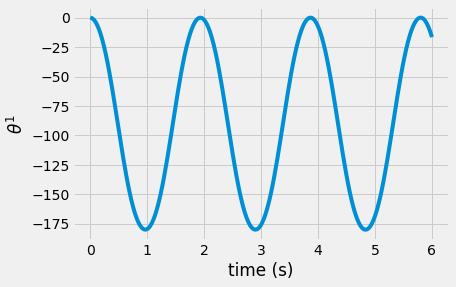

In [67]:
plt.plot(t, sol.y[2]*180/pi)
plt.xlabel('time (s)')
plt.ylabel(r'$\theta^1$')

## Animate the reaction forces

Next, you use the solution to plug into the `ode_bar` and save the reaction forces, $\mathbf{\lambda}$, as `L`. 

In [68]:
L = np.zeros((2, len(t)))
for i in range(len(t)):
    _, Li = ode_bar(t[i], sol.y[:,i], 1/h, np.sqrt(2)/h)
    L[:, i] = Li

The animation here is the center of mass and reaction force as a quiver plot. First, initialize the plot with the path of the center of mass, force vector, and center of mass location at time `t=0`. 

In [69]:
from matplotlib import animation
from IPython.display import HTML

(-0.75, 0.75)

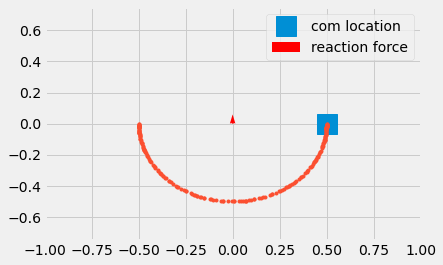

In [72]:
fig, ax = plt.subplots(1,1)
Q = ax.quiver(0, 0, -L[0,0], -L[1,0], color='r', scale = 100, label = 'reaction force')
mark, = ax.plot(sol.y[0,0], sol.y[1,0], 's', markersize = 20, label = 'com location')
ax.plot(y.y[0], y.y[1], '.')
ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(-0.75, 0.75)

Next, you set up an animation to update the quiver vector and center of mass marker to the current time. 

> __Note__: You can use the `plot_shape` to show the link, but here the goal was to see how the reaction force changes with orientation and speed. 

In [73]:
def animate(i):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """
    Q.set_UVC(-L[0,i], -L[1,i])
    mark.set_data(sol.y[0,i], sol.y[1,i])

    return Q, mark

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, animate,
                               frames = range(len(t)-1), blit=False)
HTML(anim.to_html5_video())

## Wrapping up

In this notebook, you 
- used the _augmented technique_ to set up and solve a link pinned to the ground as a dynamic system. 
- added the Baumgarte stabilization to enforce position and velocity constraints at each time step
- plotted and animated the results